In [1]:
import pandas as pd
import numpy as np
import ast
import json
import os
from df_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


cur_dir =  os.getcwd() 
sns.set(font_scale=2, style = 'white', palette = 'Set3') 


In [2]:
# get data csv
#'/data_FurnitureSliderTest_2021-11-17_16-29.csv'
filename = 'data_FurnitureSliderTest_2022-02-08_14-37.csv'
cur_dir =  os.getcwd() 
parent_dir = os.path.dirname(os.path.dirname(cur_dir))
data_path =parent_dir +'/data/think_aloud/'+filename

# transform to dataframe
df, df_model, df_ge, df_vp_sol, df_qual, df_full_time, df_actions= decompose_csv(data_path)

df_play_times = calculate_monthly_playtime(df_actions)
df_play_times['minutes'] = df_play_times.minutes.apply(float)


In [9]:
df_ge['GE09']

CASE
272    2
279    1
295    2
297    1
298    2
299    1
301    2
302    1
304    2
307    2
309    1
310    1
Name: GE09, dtype: int64

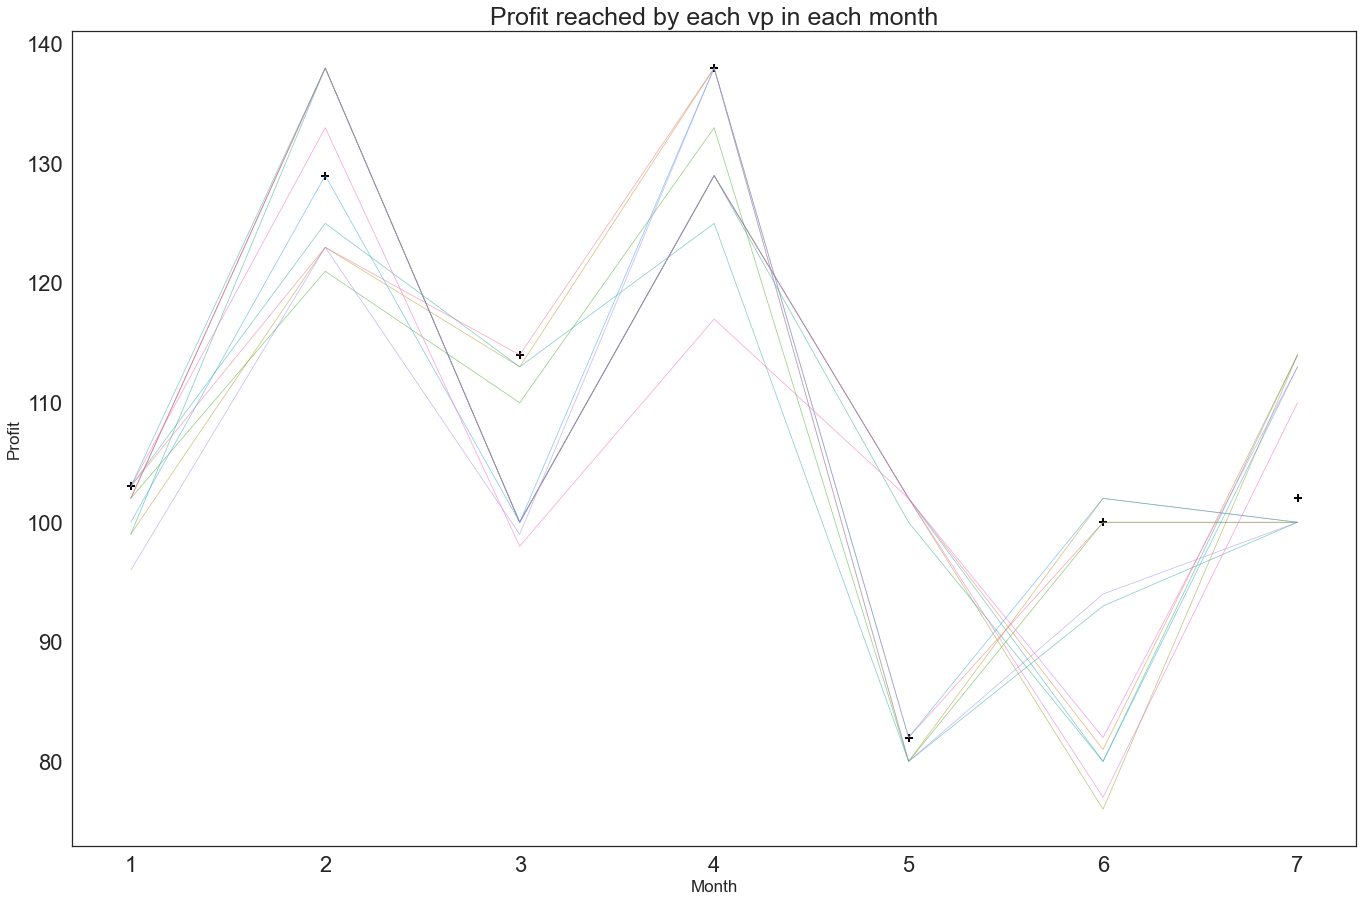

In [3]:
fig = plt.figure(figsize=(23, 15) )
plt.title('Profit reached by each vp in each month', fontsize = 25)

df_sol = pd.DataFrame(df_vp_sol.filter(regex='PL01').values, columns = list(range(1,8)))
df_sol['vp'] = range(1, len(df_sol) + 1)
df_sol = df_sol.set_index('vp')
df_sol.columns.name = 'month'
df_sol = df_sol.melt(value_name = 'solutions', ignore_index=False)#
c_map =  sns.color_palette('husl', n_colors=len(df))
#, hue =df_sol.index

data = df_sol[df_sol.month >0]
data['vp'] = data.index
data.index = range(len(data.index))
g =sns.lineplot(data = data,x='month', y = 'solutions',hue = 'vp', palette = c_map,alpha = 0.6,linewidth = 0.7, size = 10, legend = False)
scatter = sns.scatterplot(x=list(range(1,8)),y=df_model.filter(regex = 'MD01').iloc[0], s=80,  linewidth = 2,  marker = "+", color = 'black')

xlabel = plt.xlabel('Month', fontsize = 17)
ylabel = plt.ylabel('Profit', fontsize = 17)
                    
#fig.savefig('Images/performance_compared_to_optimal_individual.png' ,bbox_inches='tight')

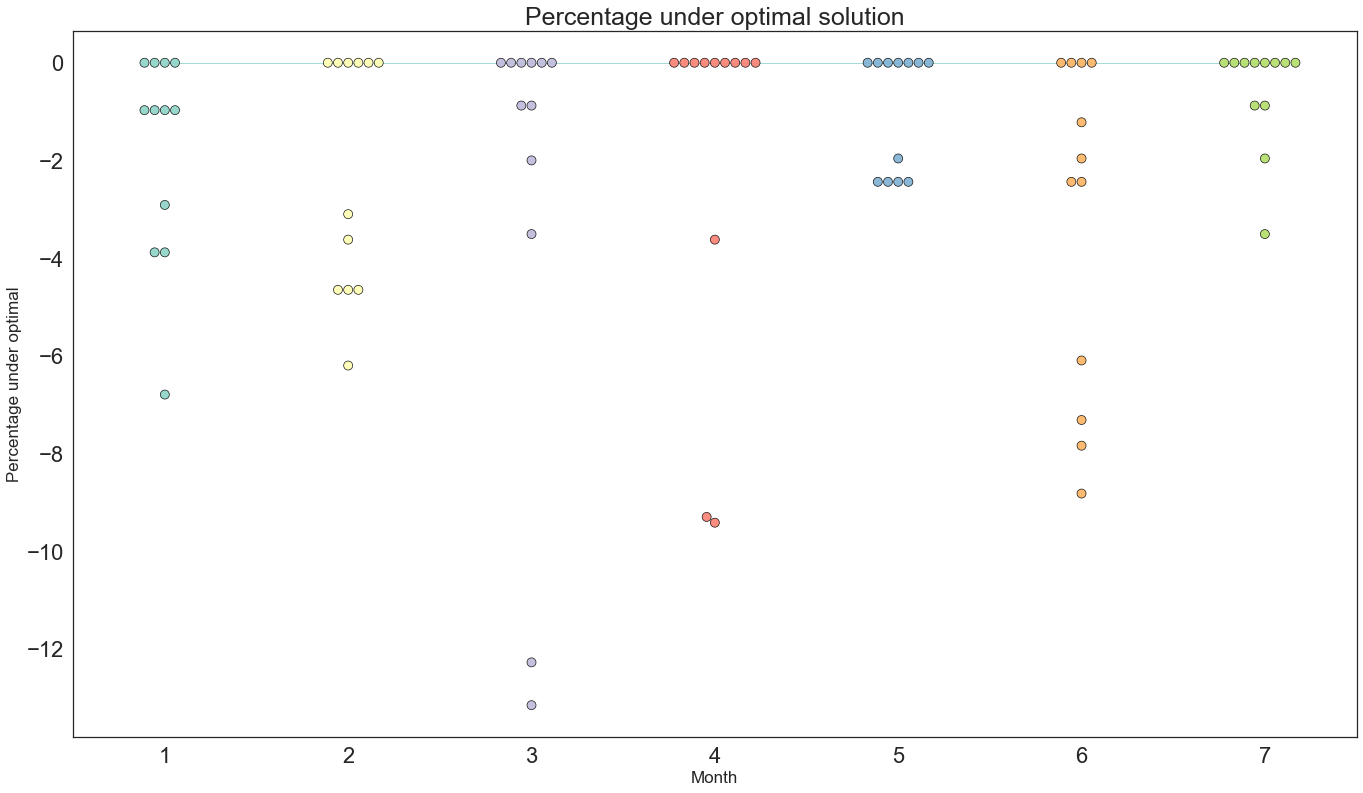

In [4]:
fig = plt.figure(figsize=(23, 13) )
plt.title('Percentage under optimal solution', fontsize = 25)
difference = []
for vp in df_vp_sol.index.unique():
    diff= ((df_vp_sol[df_vp_sol.index == vp].filter(regex='PL01').values/
            df_model[df_model.index == vp].filter(regex = 'MD01').values[0])-1)*100
    difference.append(diff[0])
df_diff = pd.DataFrame(difference, columns = list(range(1,8)))
df_diff['vp'] = range(1, len(df_diff) + 1)
df_diff = df_diff.set_index('vp')
df_diff.columns.name = 'month'

df_plot = df_diff.melt(value_name = 'difference', ignore_index=False)#
sns.lineplot(x=list(range(7)),y=np.zeros(7), linewidth = 0.8)
sns.swarmplot(data = df_plot,x='month', y = 'difference', alpha = 0.9,  size = 9,linewidth = 0.7, edgecolor="black")
xlabel = plt.xlabel('Month', fontsize = 17)
ylabel = plt.ylabel('Percentage under optimal', fontsize = 17)

fig.savefig('Images/difference_to_optimal.jpg',bbox_inches='tight')

In [5]:

def get_unique_states(vp, df_actions):
    all_unique_states = []

    for m in range(2,8):
        df_vp = df_actions.loc[(df_actions.action_type == 'successful built') & (df_actions.month == m) 
                            & (df_actions.vp == vp),['chairs', 'tables', 'bookcases', 'beds']]
        unique_states = []
        state = [0,0,0,0]
        for index, row in df_vp.iterrows():
           
            if list(row.values) != state:
                state = list(row.values)
                unique_states.append(state)
        all_unique_states.append(unique_states)

    return all_unique_states
def plot_decision_trajectories(vp, df_actions):
    
    all_unique_states = get_unique_states(vp, df_actions)
    for f in range(2):  
        
        fig, axes = plt.subplots(3, 1, figsize=(35, 17.5))

        colormap =  sns.cubehelix_palette(n_colors=20, start=0, rot=-0.5, gamma=1.0, hue=0.8, light=0.9, dark=0.3)

   #     fig.suptitle('Player trajectory of subject ' + str(vp) + ' for months '+ str(f*4+1)+'- '+str(f*4+4)+' ', fontsize = 30)
        c, j = 0,0
        for i in range(f*2+f,f*3+3):
           # df_month = df_solution_paths[(df_solution_paths.vp == vp) &(df_solution_paths.month == i) ]
           # df_month = df_month.sort_values(by ='steps' )
           # x_axis_labels = df_month['steps'] # labels for y-axis
            axes[c].set_title('Month {}'.format(i+1), fontsize = 20)
           # sns.set(font_scale=1.6)
            df_built = pd.DataFrame(all_unique_states[i], columns = ['chairs', 'tables', 'bookcases', 'beds'])
            sns.heatmap(ax = axes[c],
                        data = df_built.transpose(),
                        cbar = None,
                        cmap = colormap,
                       # xticklabels=x_axis_labels,  
                        annot = True)#, linewidths=1)
          #  if i == 3:
          #      axes[i].set_xlabel('steps', fontsize=20)
            c+=1
        for ax in axes:
            ax.tick_params(axis = 'y',labelrotation=0)
            ax.tick_params(axis = 'x',labelrotation=0)
            ax.tick_params(axis='both', which='major', labelsize=20)
            
        ax.set_xlabel('trajectory step', fontsize=20)
      #  fig.tight_layout()

        fig.savefig('Images/vp_'+str(vp) +'/unique_changes_furniture_built_'+ str(f*2+f+1)+'_'+str(f*3+3)+'_vp_solutions.png')


In [5]:
df_model[df_model.index == vp].filter(regex = 'MD01').values[0]

array([103, 138, 100, 129, 102,  82, 114])

In [6]:
def plot_basic_statistics(vp, df_vp_sol, df_model, df_play_times):
    '''Plots Profit, Difference to optimal solution & playing times''' 
    
    fig = plt.figure(figsize=(18, 15))
    fig.subplots_adjust(bottom=0.25, left=0.025, top = 0.975, right=0.975)   
    fig.tight_layout()
    
    # profit over months
    sub = fig.add_subplot(2,1,1)
    sub.title.set_text('Profit reached by vp ' + str(vp)+ ' in each month')


    df_sol = pd.DataFrame(df_vp_sol[df_vp_sol.index == vp].filter(regex='PL01').values, columns = list(range(1,8)))
    df_sol.columns.name = 'month'
    df_sol = df_sol.melt(value_name = 'solutions', ignore_index=False)#
    g =sns.lineplot(data = df_sol[df_sol.month >0],x='month', y = 'solutions', ax = sub, color = 'darkgreen')
    sns.scatterplot(data = df_sol[df_sol.month >0],x='month', y = 'solutions',ax = sub, color = 'darkgreen', s =80)
    scatter = sns.scatterplot(x=list(range(1,8)),y=df_model[df_model.index == vp].filter(regex = 'MD01').values[0], s=80,  
                              linewidth = 2,  marker = "+", color = 'black', ax = sub)

    xlabel = plt.xlabel('Month', fontsize = 17)
    ylabel = plt.ylabel('Profit', fontsize = 17)
    #sub.set_ylim([12,200])
    
    # difference to optimal
    sub1 = fig.add_subplot(2,2,3)
    sub1.title.set_text('Percentage under optimal solution vp ' + str(vp))

    difference = ((df_vp_sol.filter(regex='PL01').values/df_model[df_model.index == vp].filter(regex = 'MD01').values[0])-1)*100
    df_diff = pd.DataFrame(difference, columns = list(range(1,8)))
    df_diff = df_diff.set_index(df_vp_sol.index.unique())
    df_diff.columns.name = 'month'

    df_plot = df_diff.melt(value_name = 'difference', ignore_index=False)#
    sub1.axhline(0, color = 'gray')
    sns.lineplot(data = df_plot[df_plot.index == vp],x='month', y = 'difference',ax = sub1, color = 'orange')
    sns.scatterplot(data = df_plot[df_plot.index == vp],x='month', y = 'difference', ax = sub1, color = 'orange',
                    s =80)

    xlabel = plt.xlabel('Month', fontsize = 17)
    ylabel = plt.ylabel('Percentage under optimal', fontsize = 17)
    sub1.set_ylim([-15,1])

    # times
    sub2 = fig.add_subplot(2,2,4)   
    sub2.title.set_text('Playing times in each month')
   # sub2.title('Playing times in each month', fontsize = 20)
    sns.lineplot(data = df_play_times[(df_play_times.index == vp) &(df_play_times.month > 0) ],x='month', y = 'minutes', 
                 color = 'darkblue', ax = sub2)
    sns.scatterplot(data = df_play_times[(df_play_times.index == vp) &(df_play_times.month > 0) ],x='month', y = 'minutes', ax = sub2, s =80)
    #sub2.axhline(3, color = 'sienna')
    xlabel = plt.xlabel('Month', fontsize = 17)
    ylabel = plt.ylabel('Time in Minutes', fontsize = 17)
    #sub2.set_ylim([0,10])
    fig.savefig('Images/vp_'+str(vp) + '/basic_stats_vp_' + str(vp) +'.png',bbox_inches='tight')



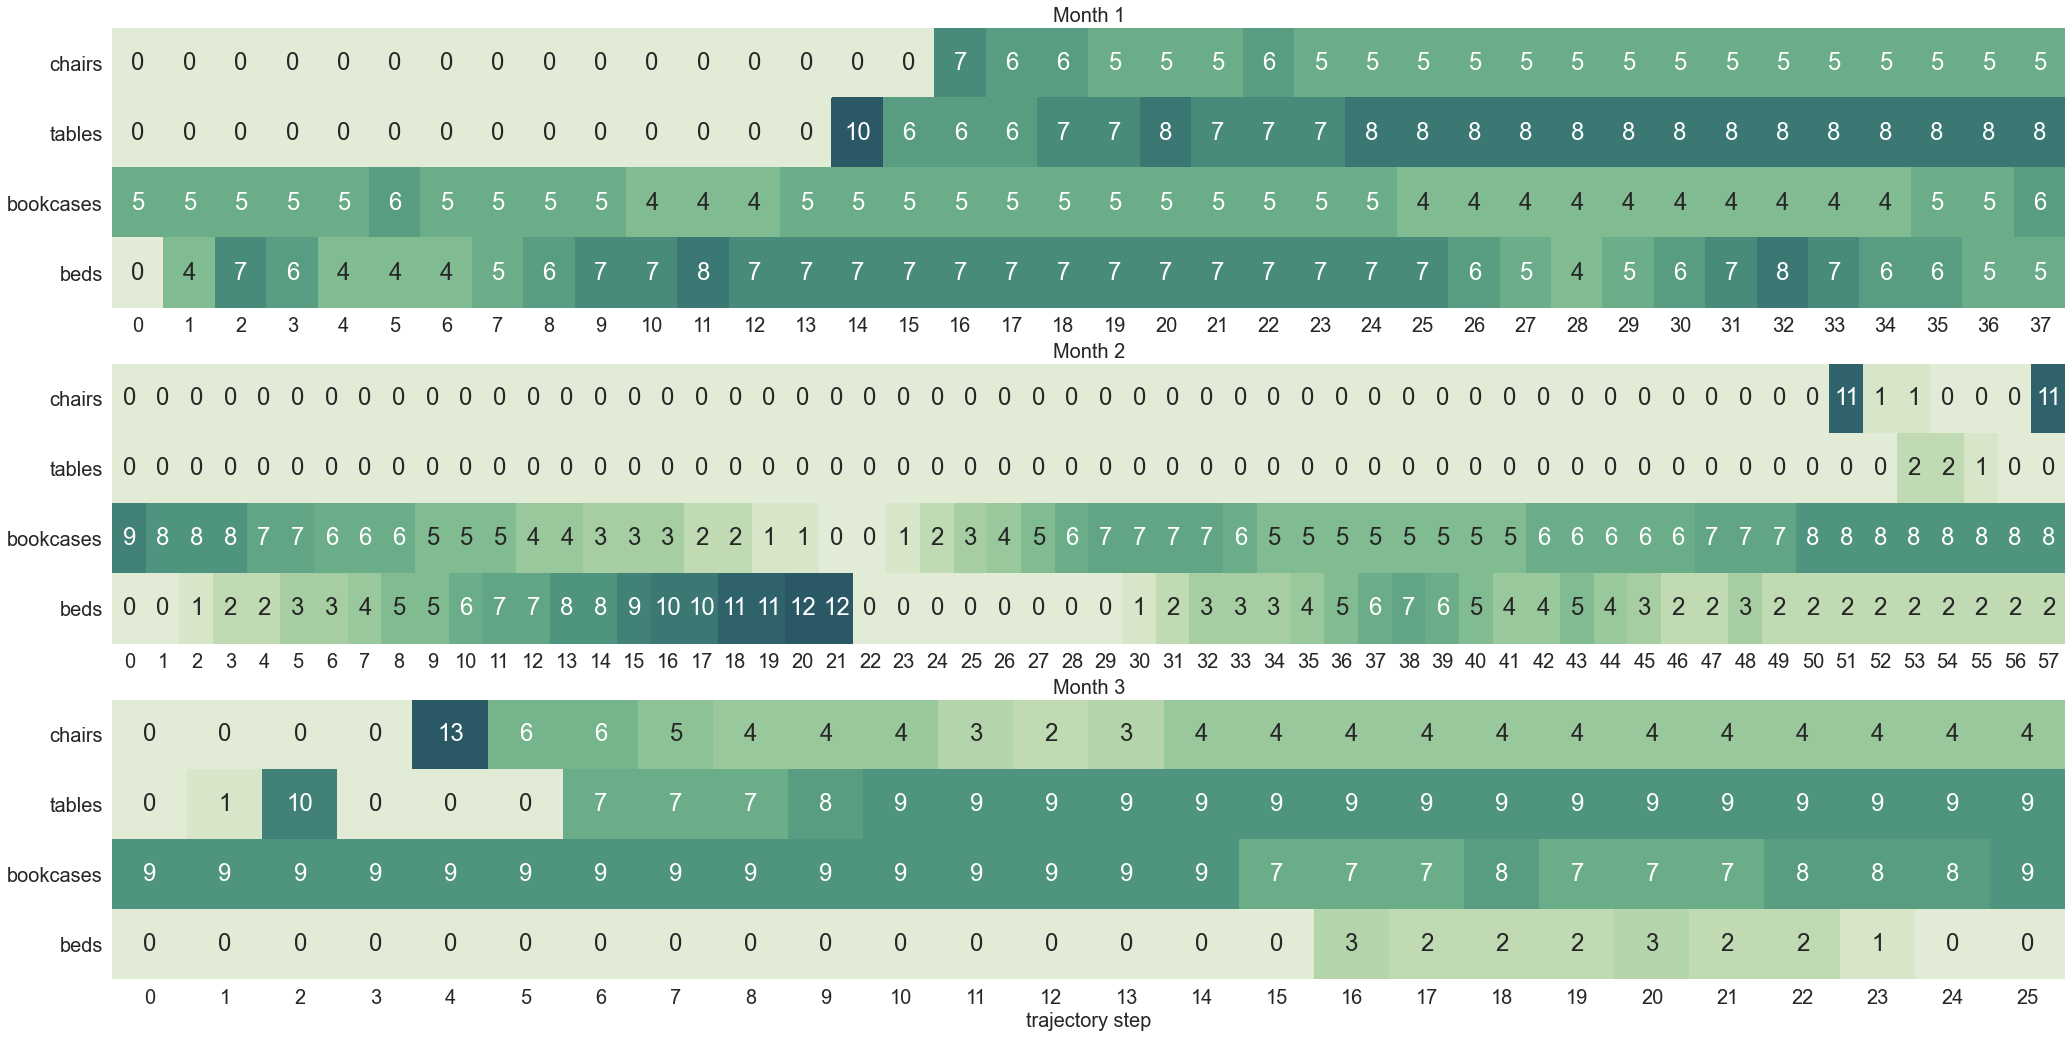

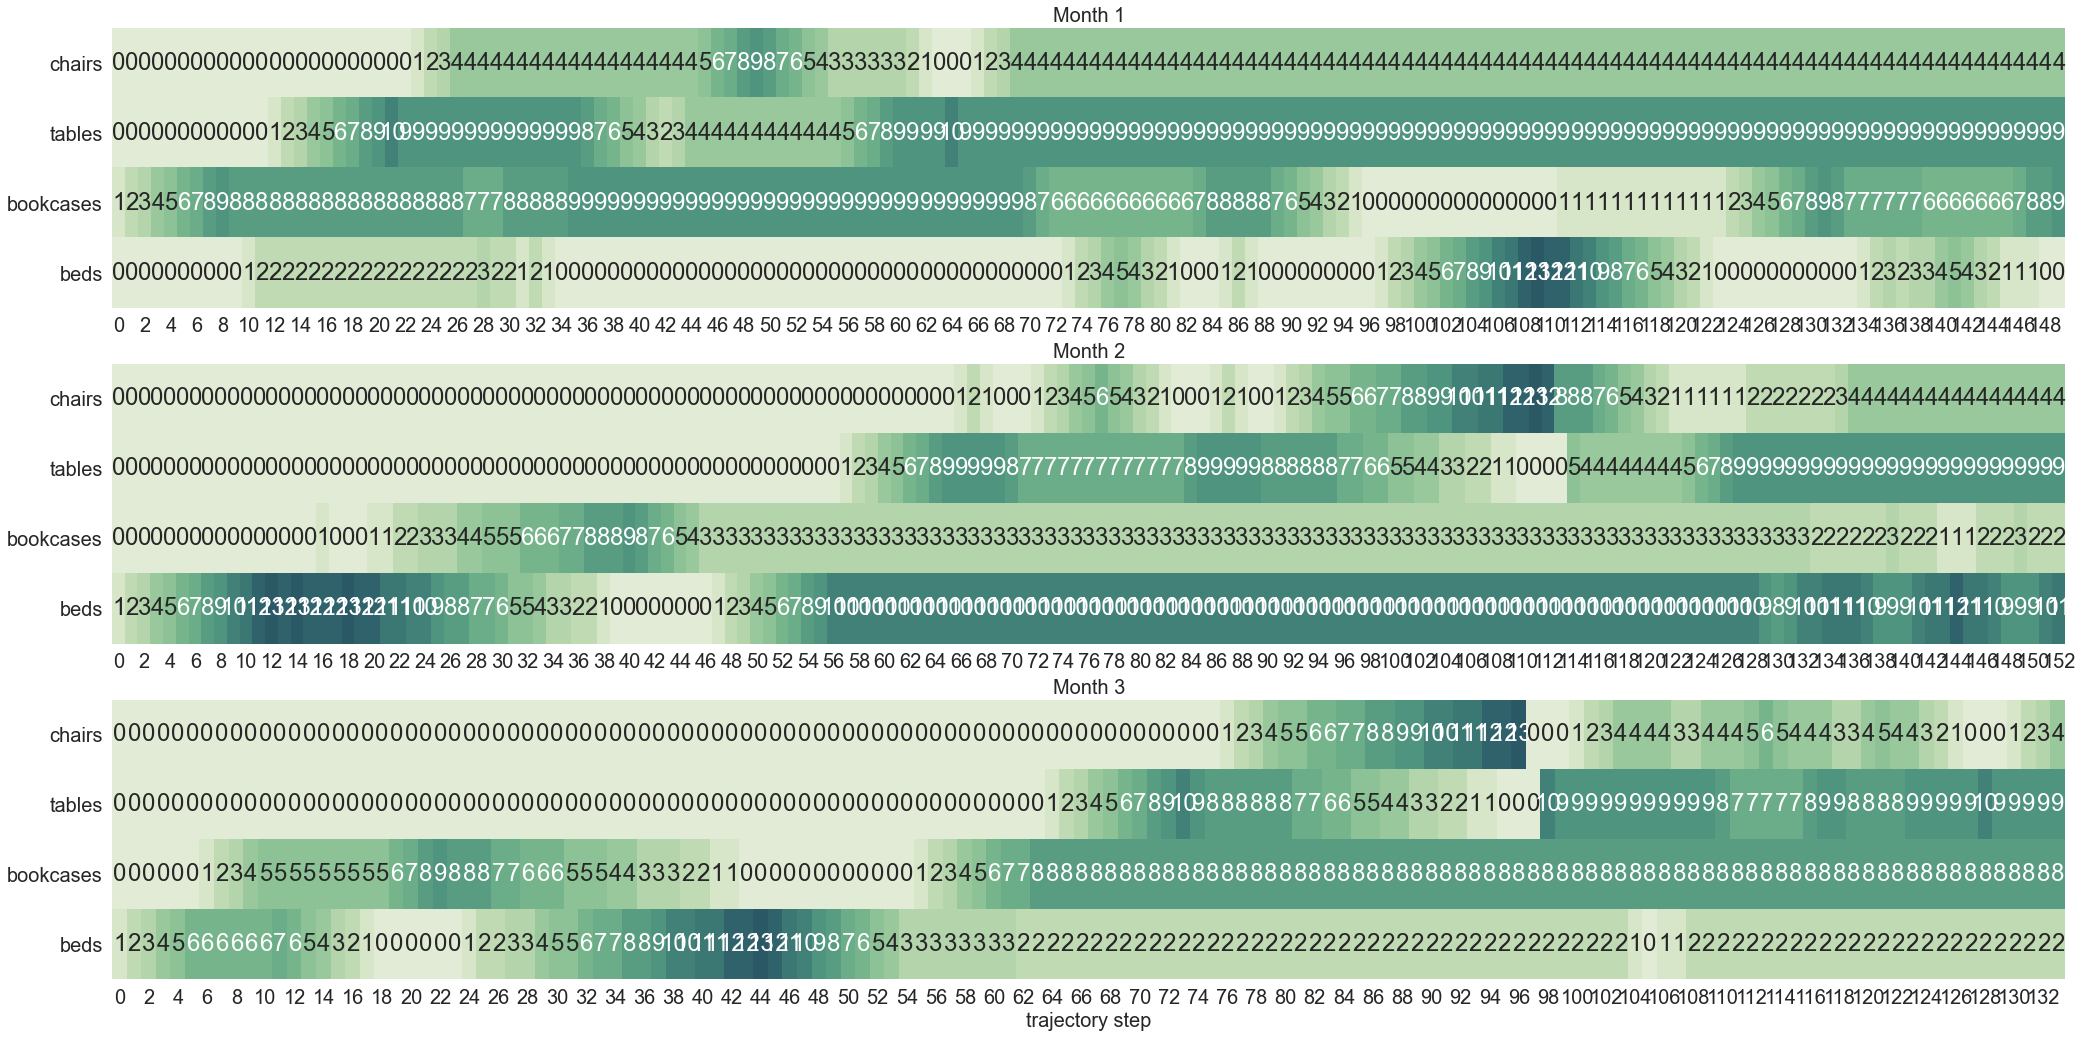

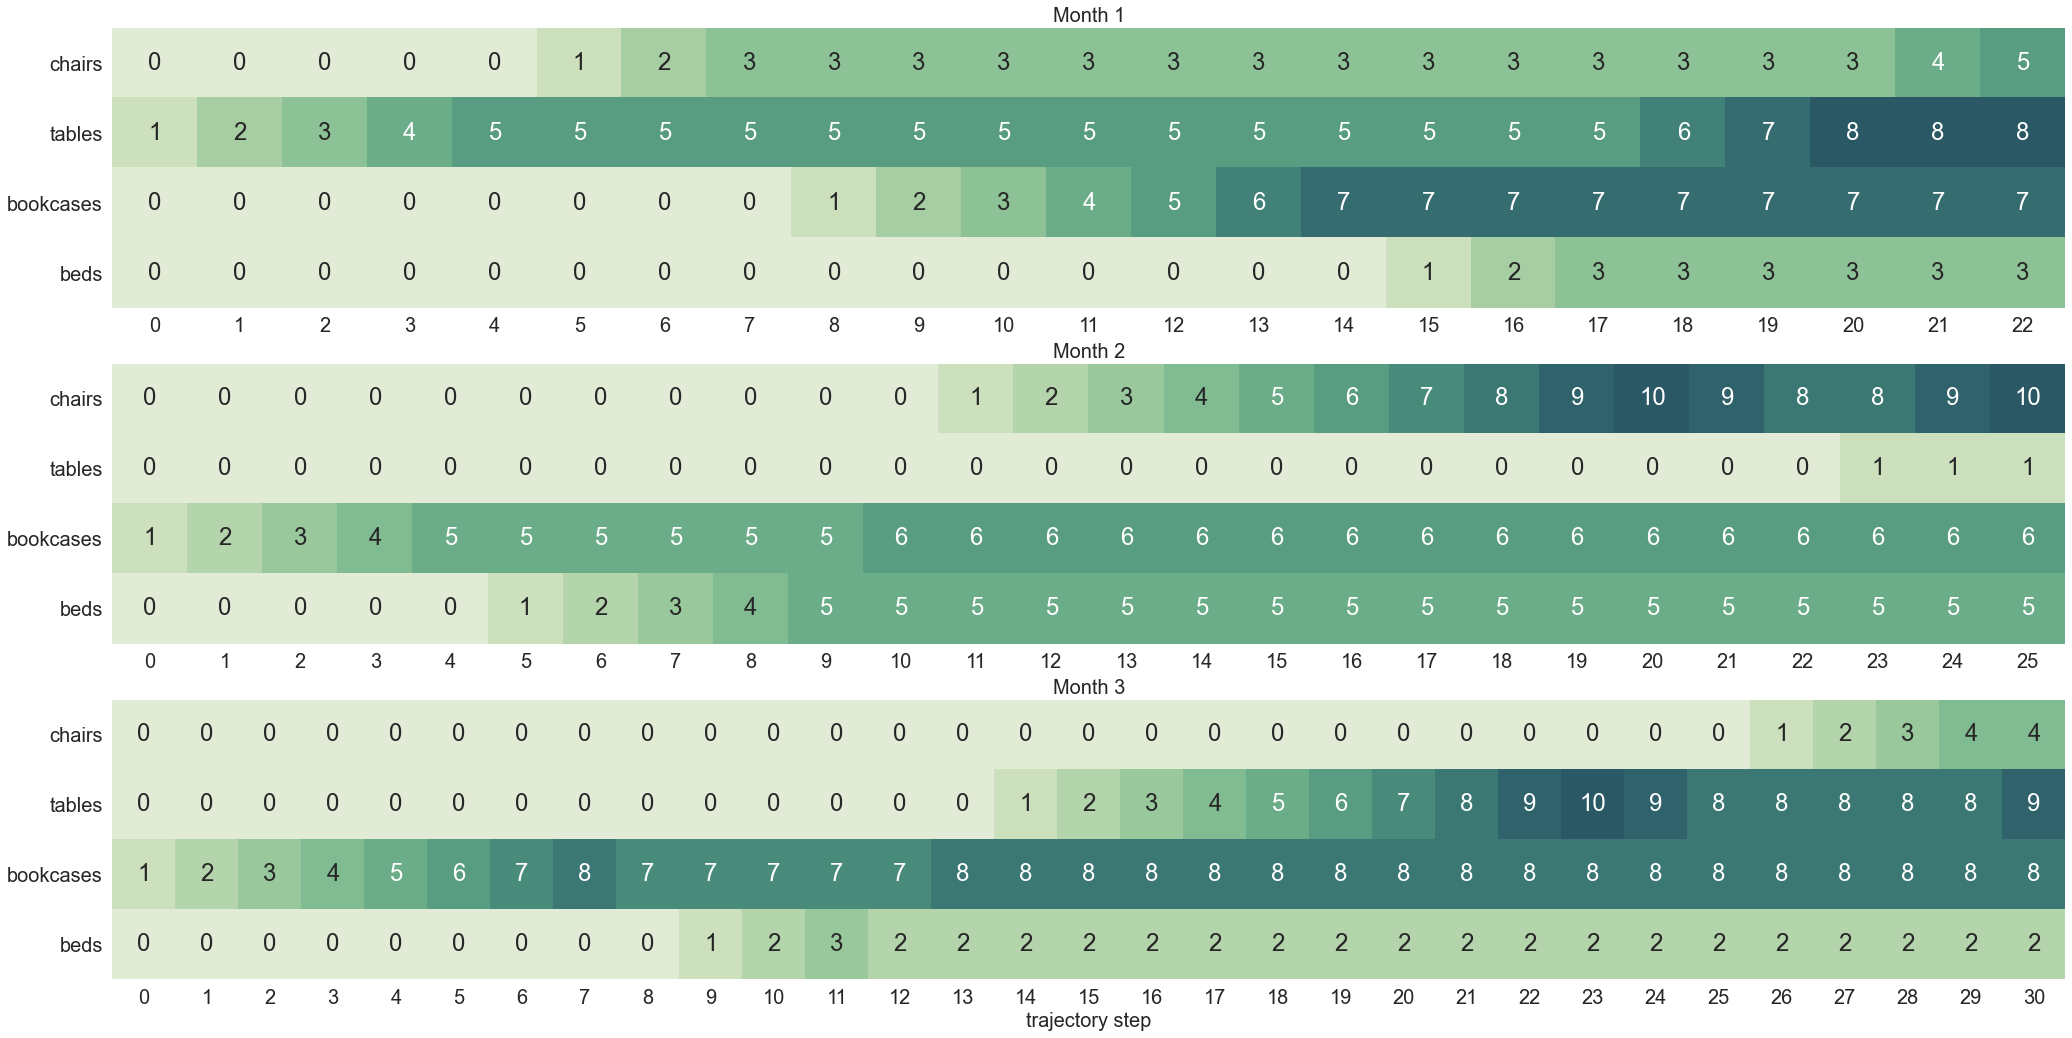

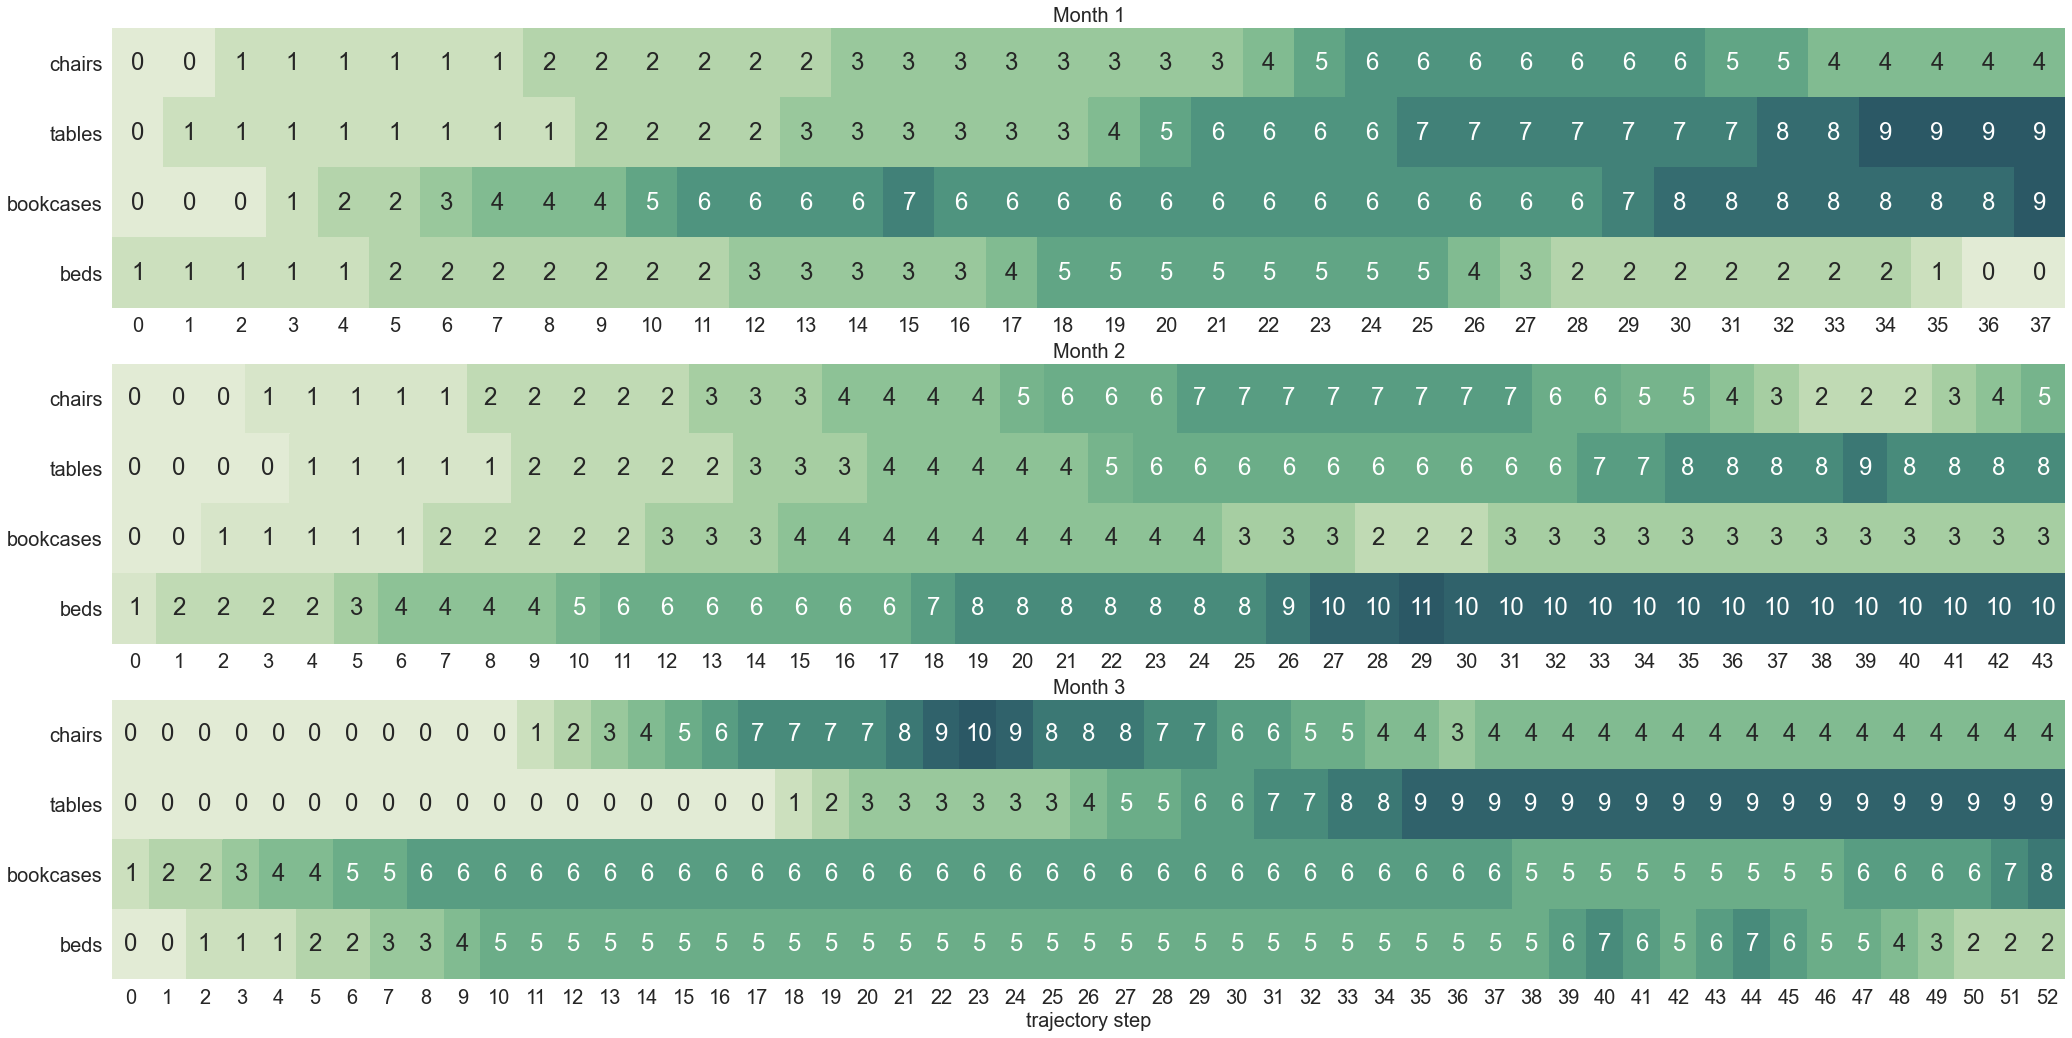

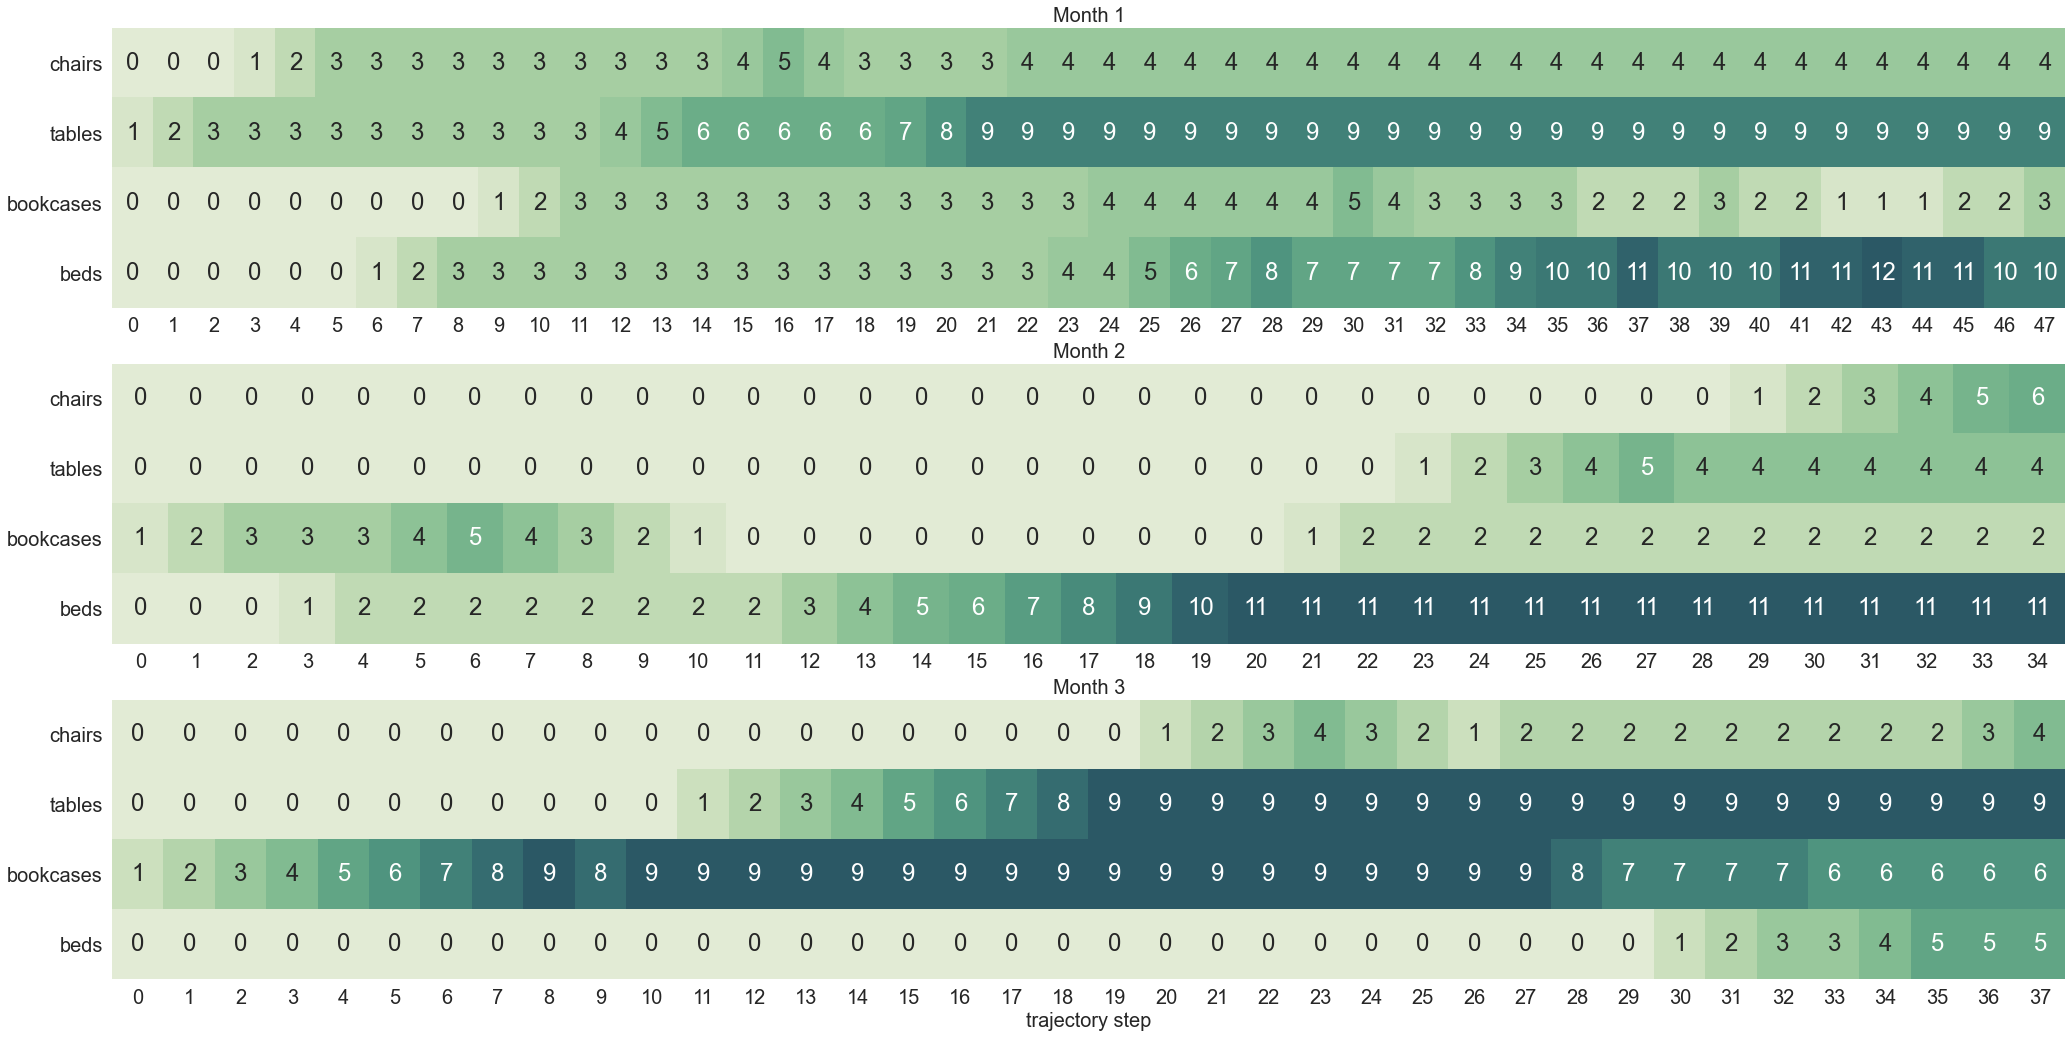

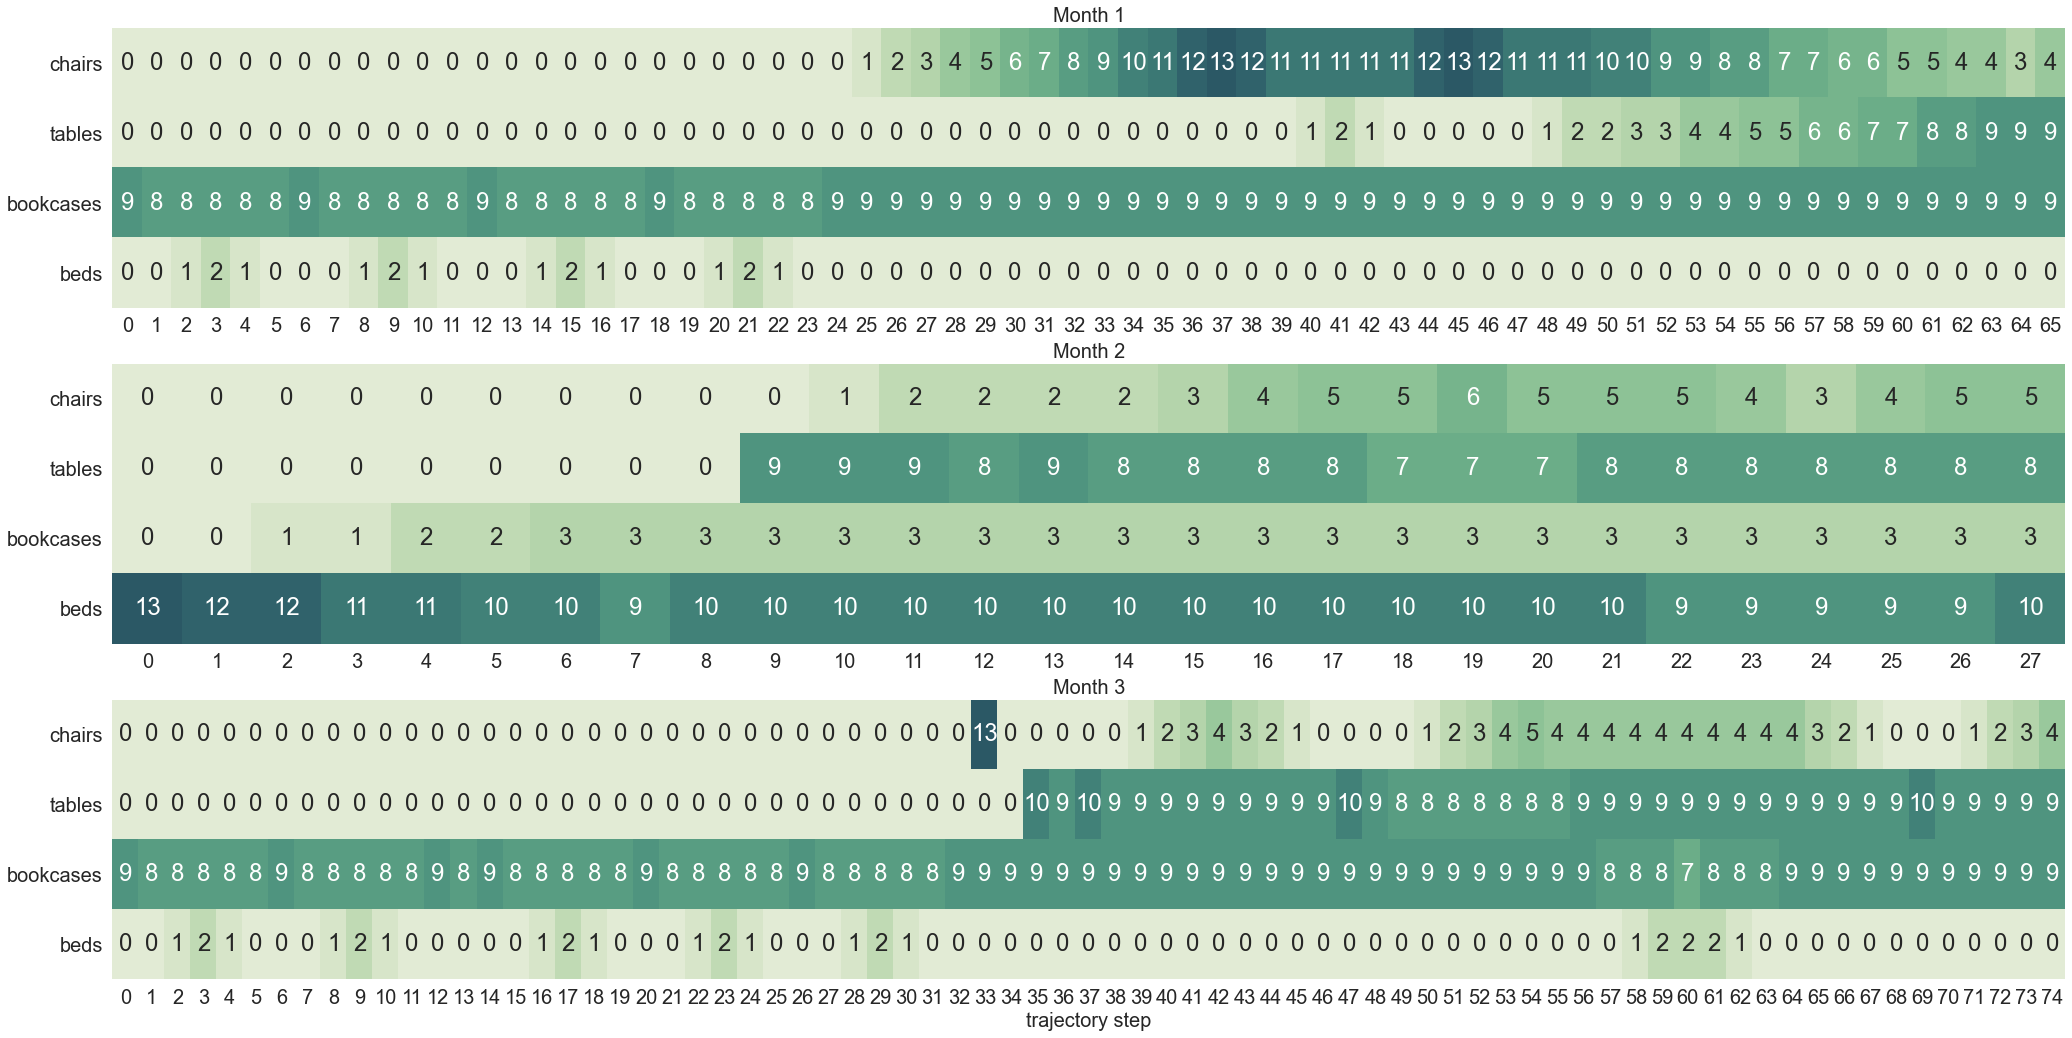

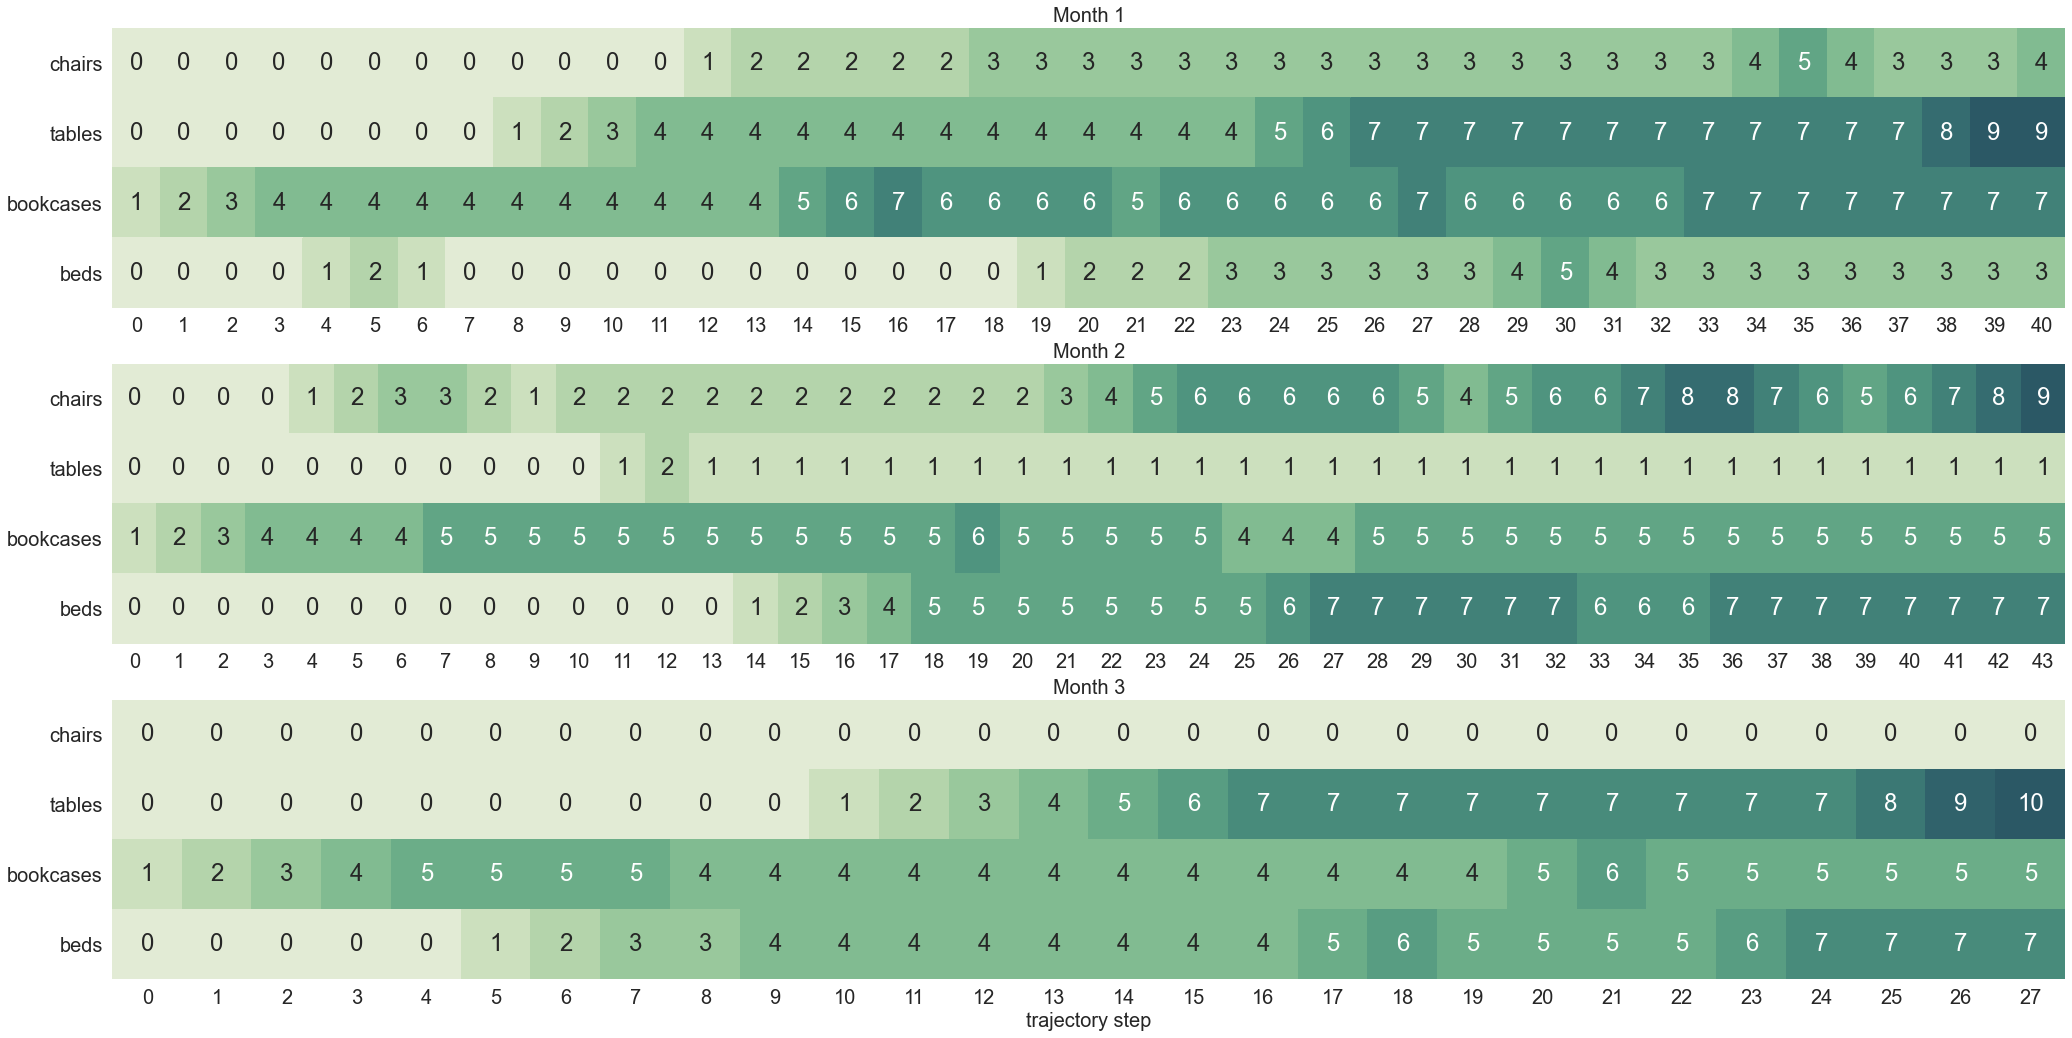

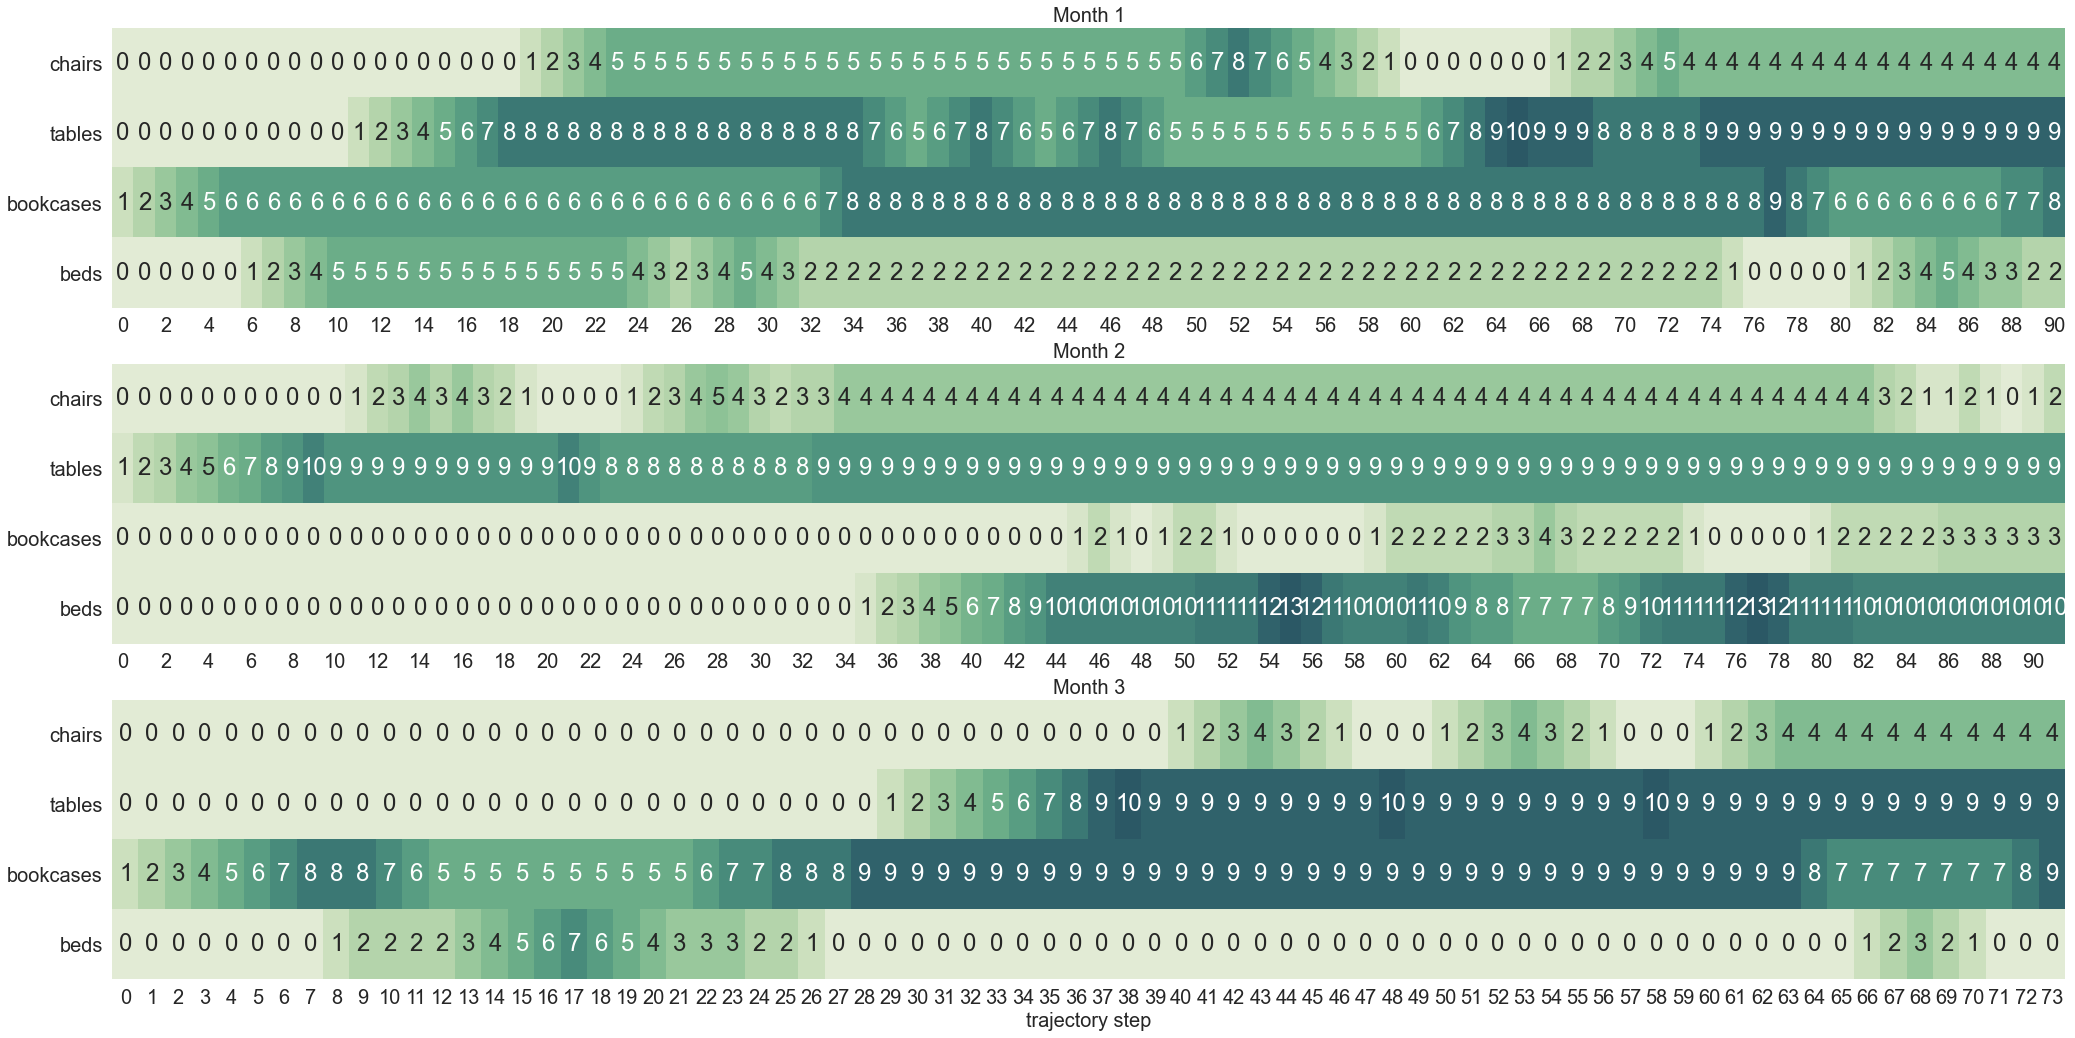

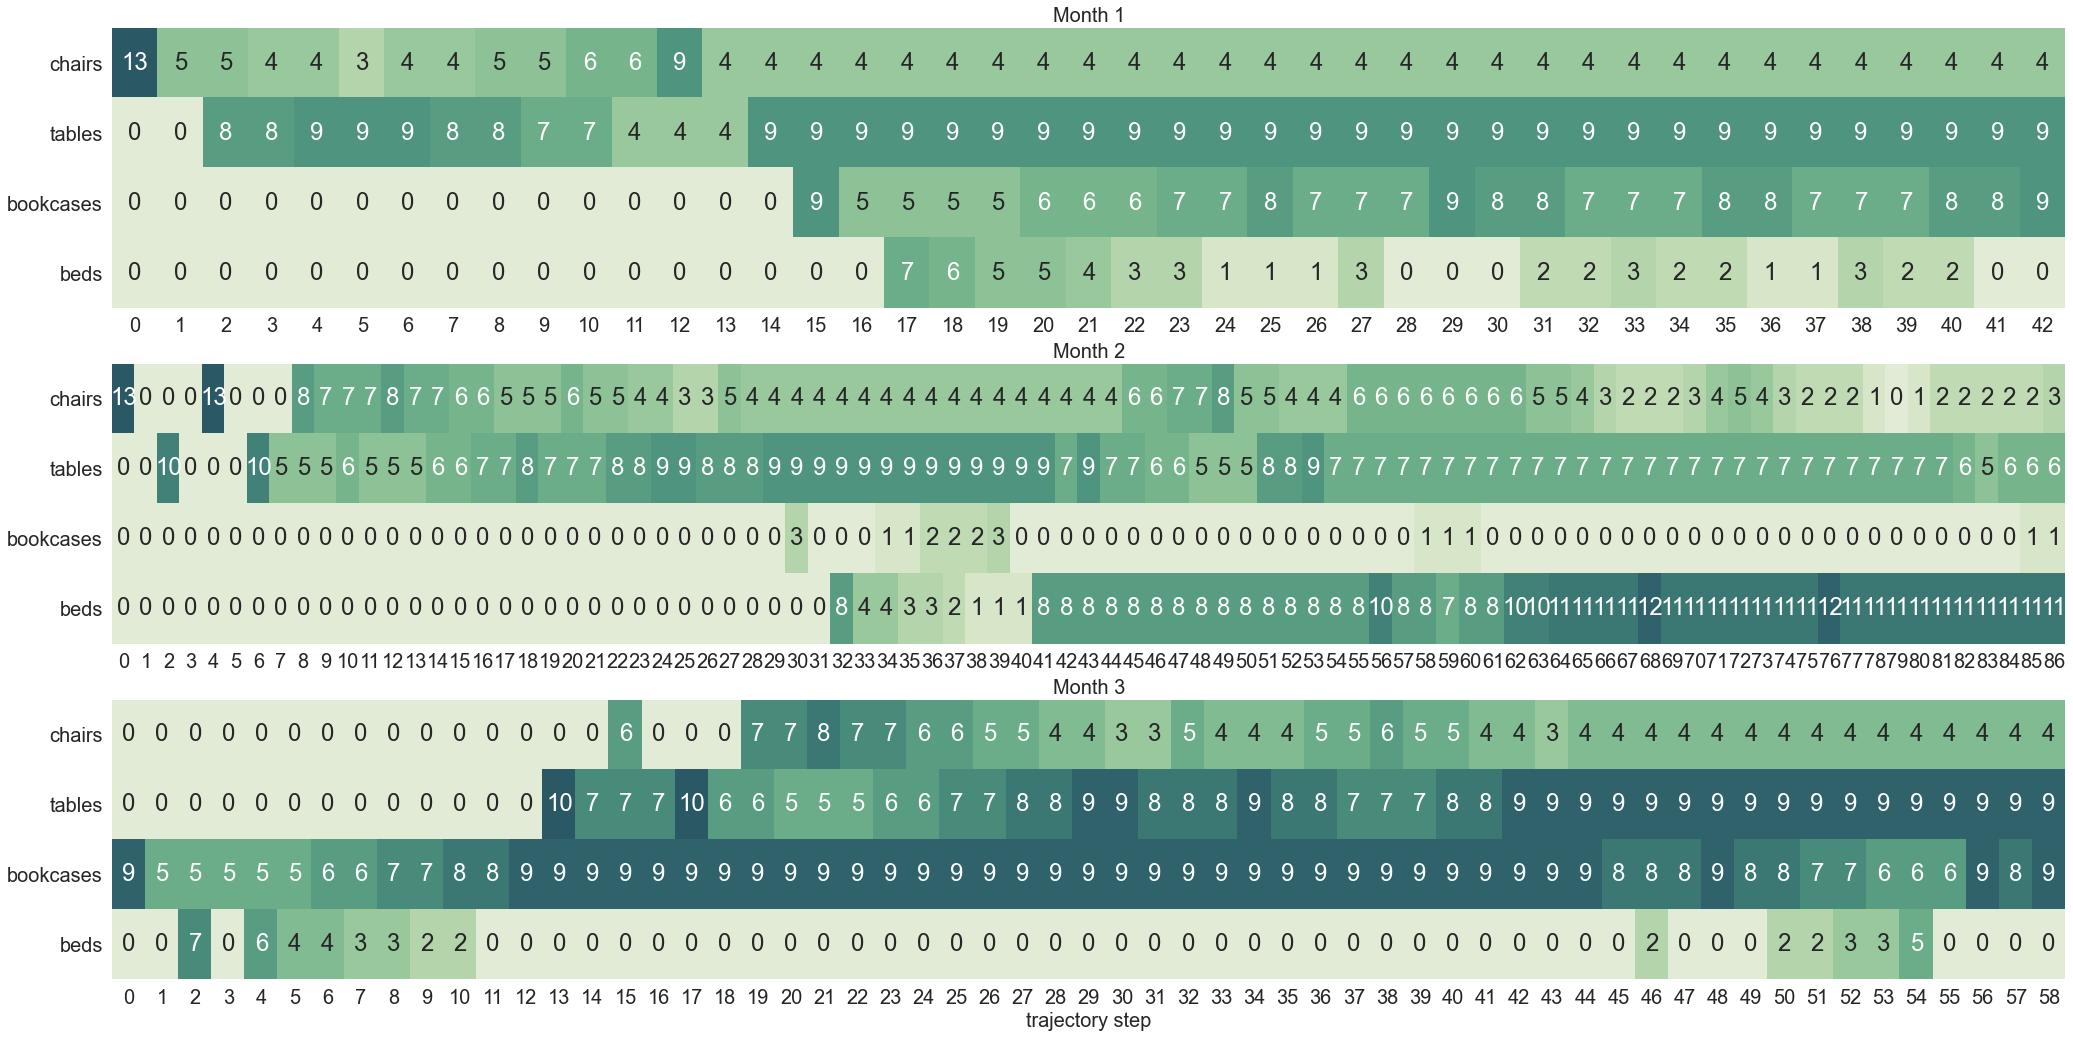

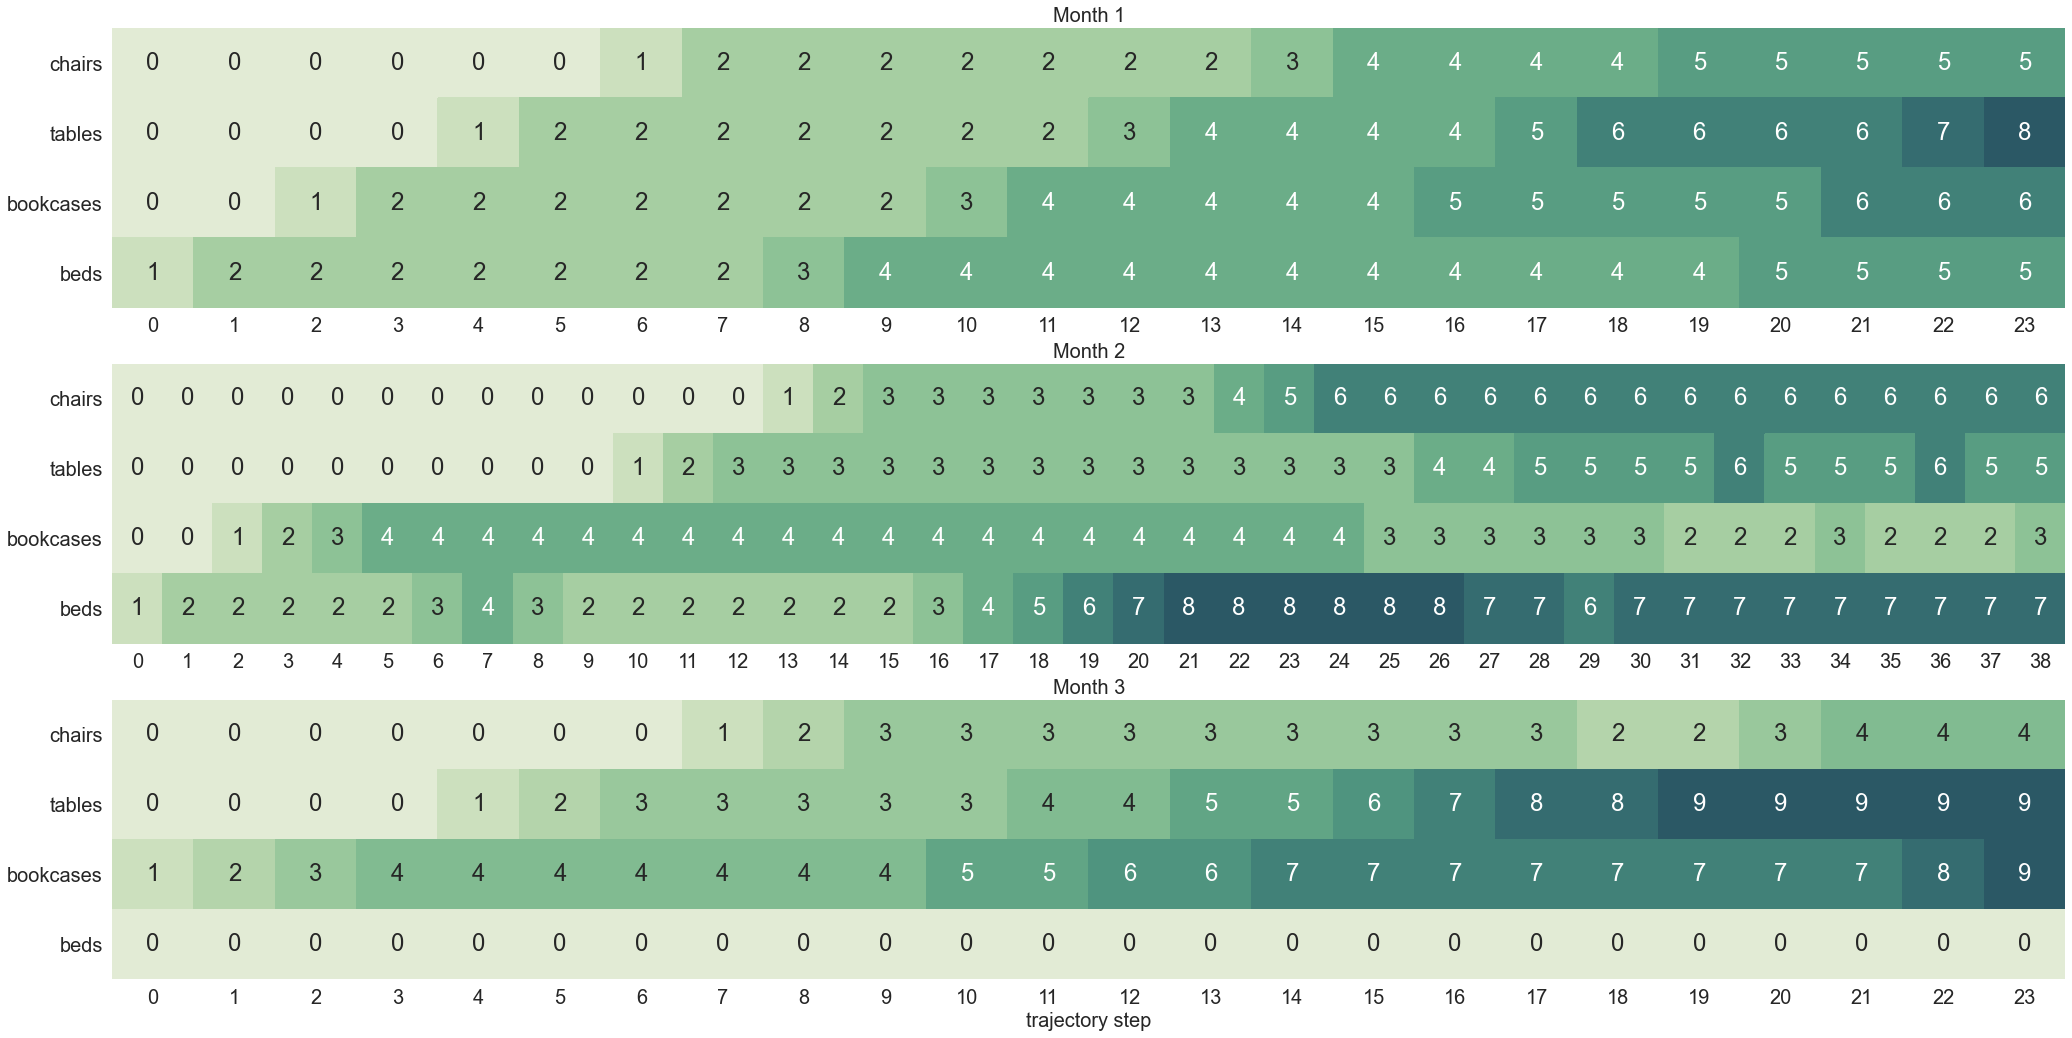

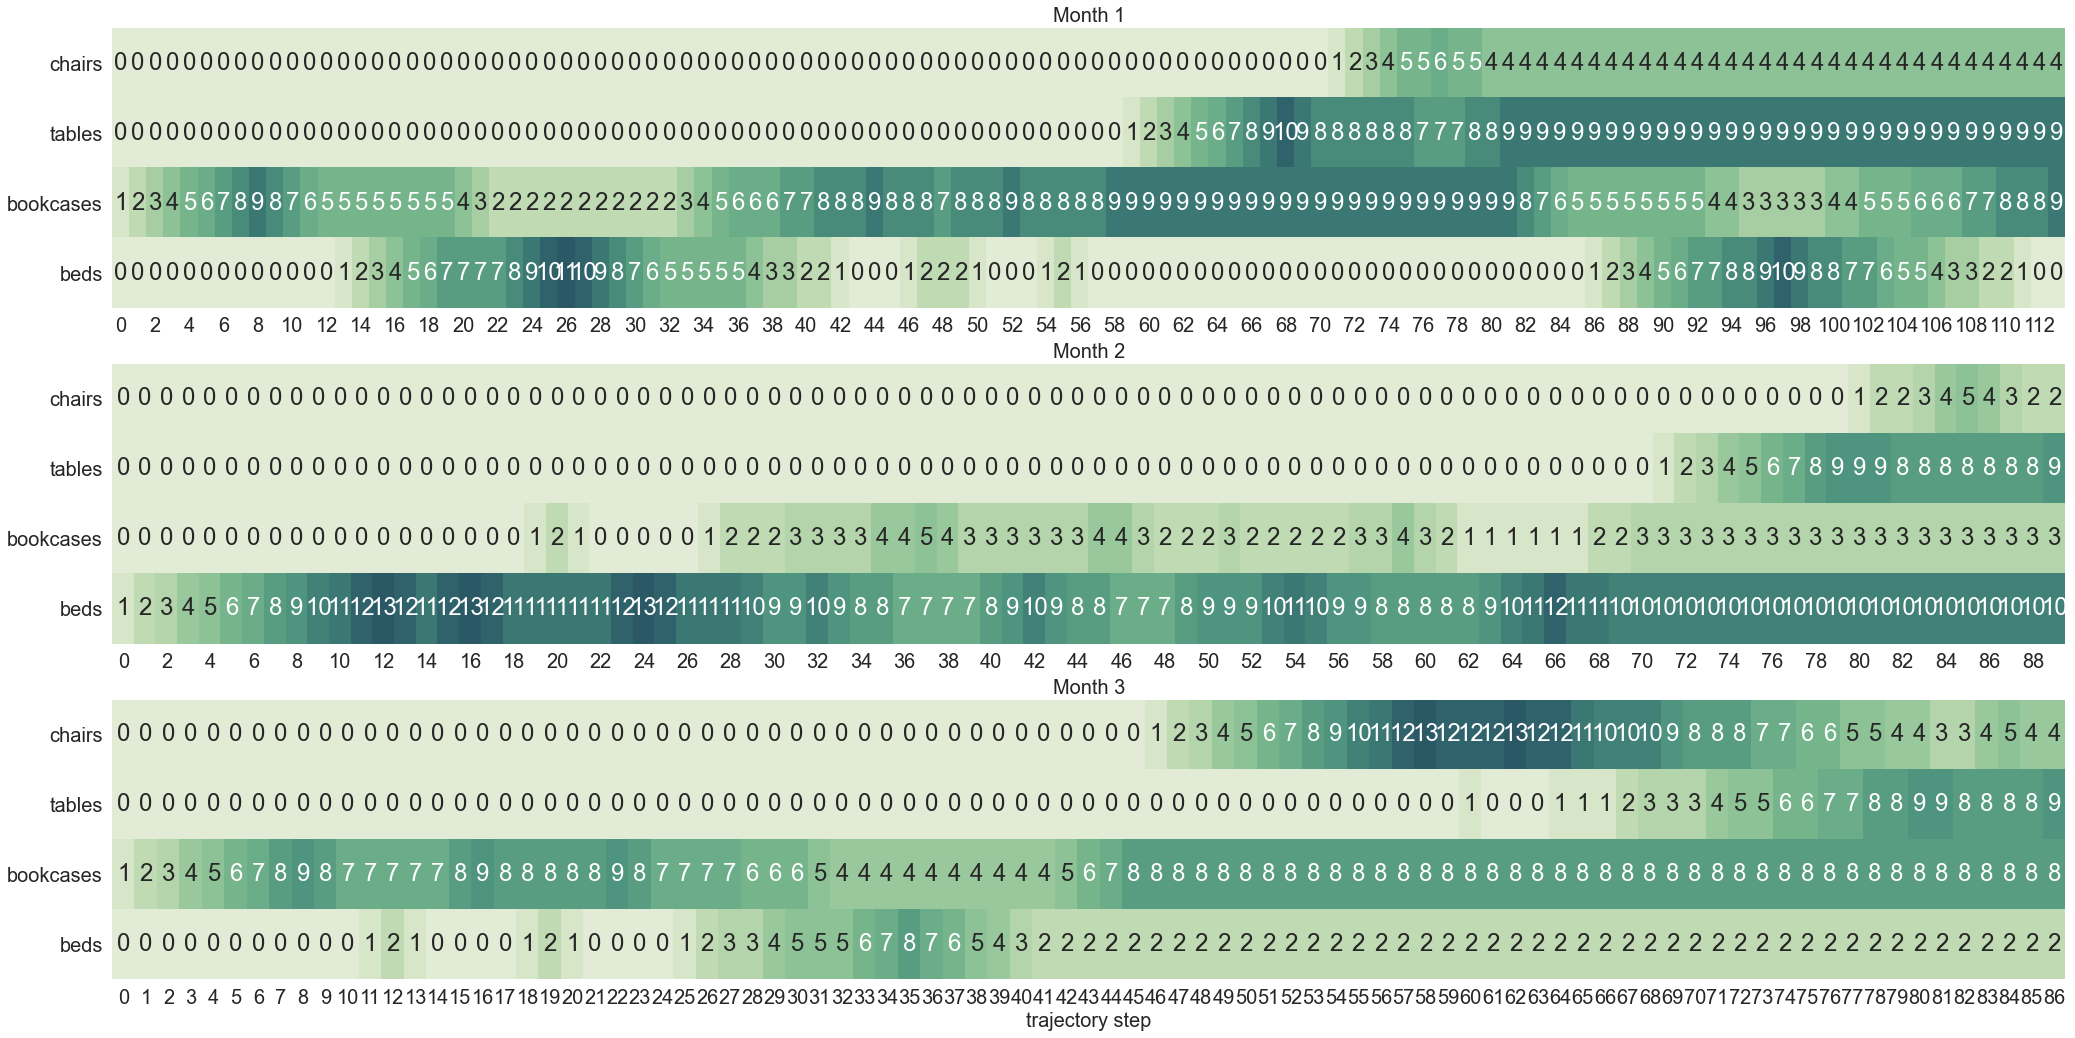

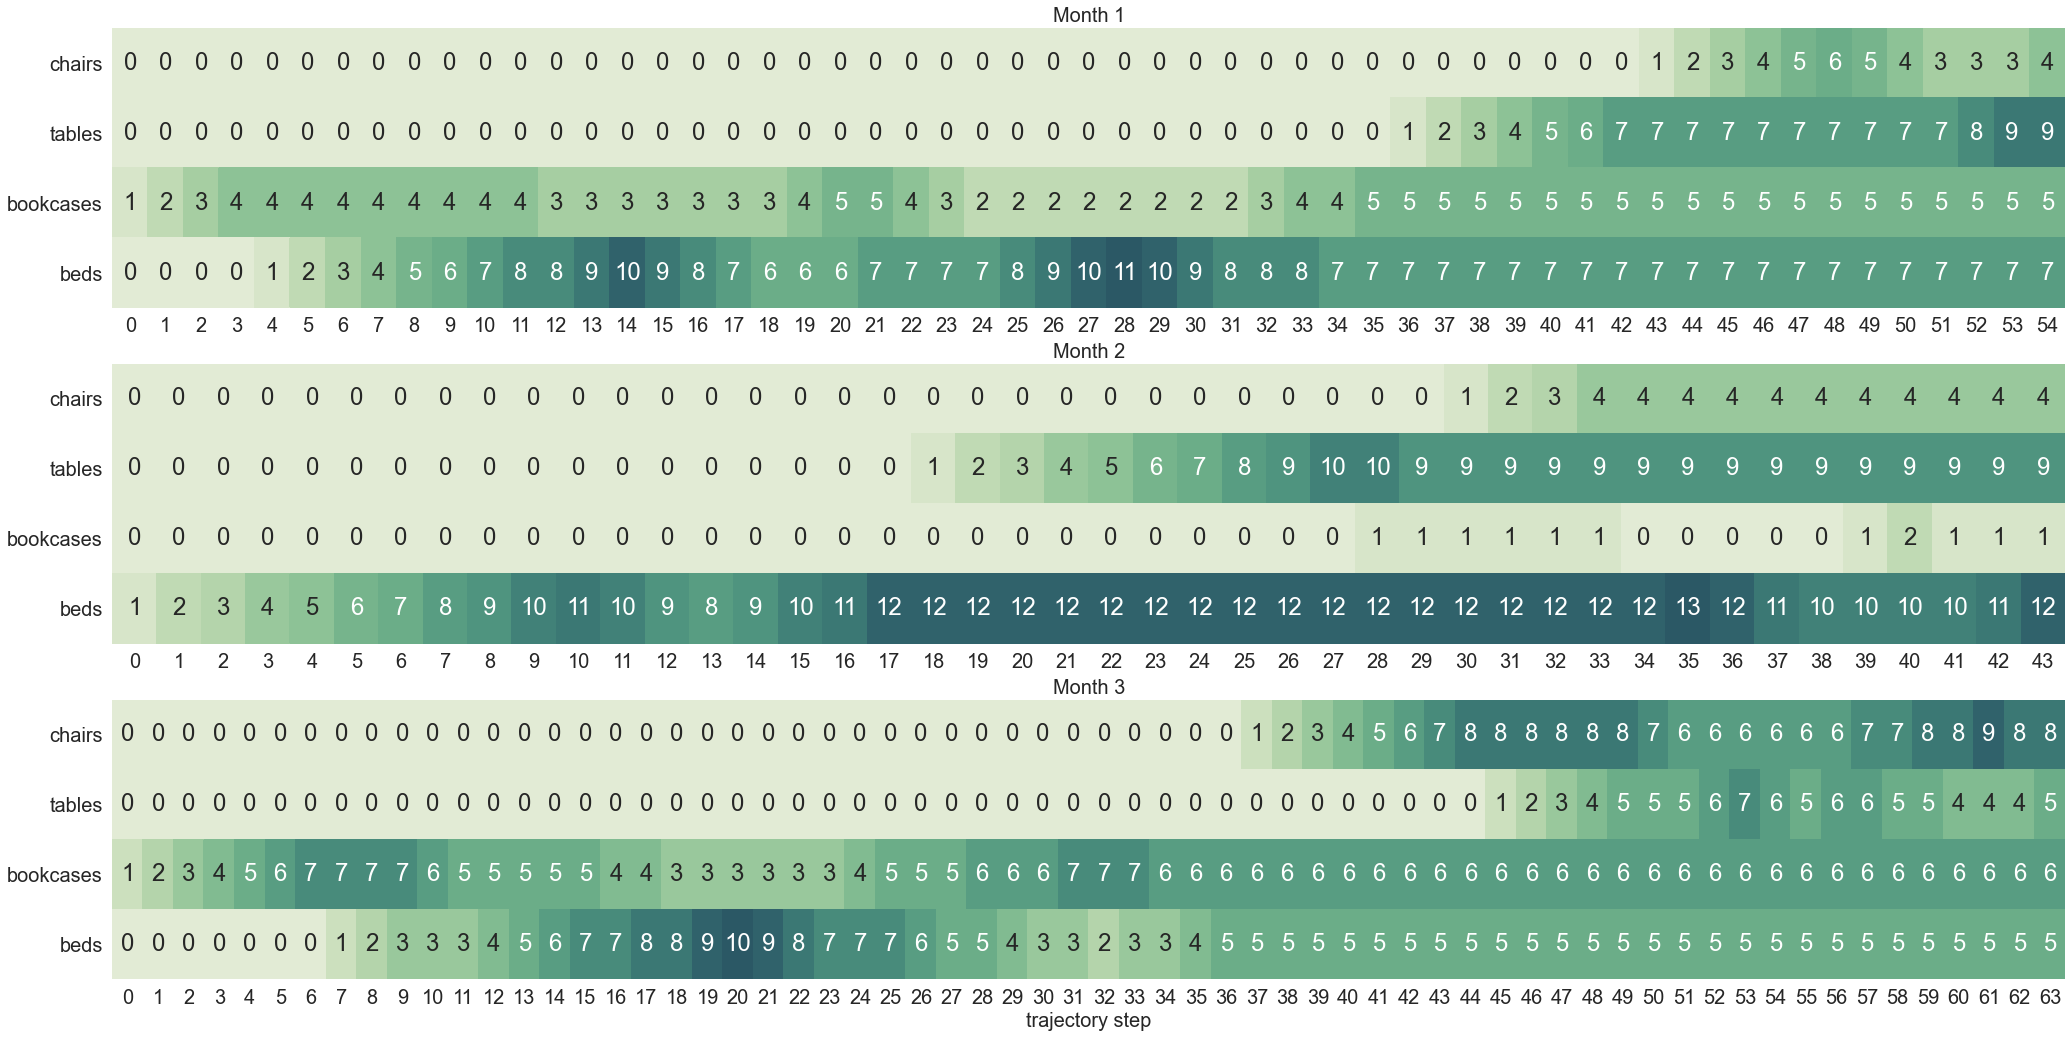

In [7]:
for vp in df_actions['vp'].unique():

    directory = 'Images/vp_'+str(vp) + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    plot_decision_trajectories(vp, df_actions)  
    plt.close()
    plot_basic_statistics(vp, df_vp_sol, df_model, df_play_times)
    plt.close()
